In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Rescaling

import tensorflow as tf
import os

import numpy as np
import random
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Directory path
train_dir = '/content/sports-balls-multiclass-image-classification/train'

# Dictionary to store subdirectory names and file counts
data = {'Category': [], 'Image Count': []}

# Loop through each subdirectory
for sub_dir in os.listdir(train_dir):
  sub_dir_path = os.path.join(train_dir, sub_dir)
  if os.path.isdir(sub_dir_path):
    # Count the number of files (images) in the subdirectory
    num_files = len([f for f in os.listdir(sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path, f))])
    data['Category'].append(sub_dir)
    data['Image Count'].append(num_files)

In [4]:
import pandas as pd
df = pd.DataFrame(data)

In [5]:
df

,Category,Image Count
0,rugby_ball,493
1,football,604
2,golf_ball,549
3,hockey_ball,530
4,tennis_ball,490
5,basketball,340
6,billiard_ball,646
7,bowling_ball,440
8,hockey_puck,390
9,cricket_ball,581


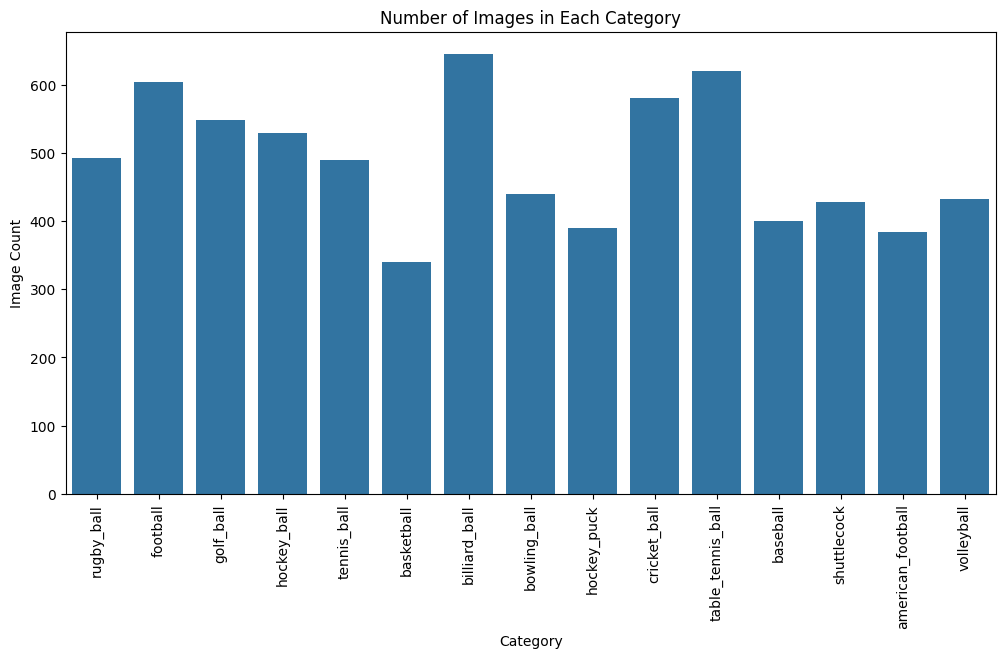

In [6]:
# Create the bar plot using Seaborn
plt.figure(figsize = (12, 6))
sns.barplot(x = 'Category', y = 'Image Count', data = df)
plt.xticks(rotation=90)
plt.title('Number of Images in Each Category')
plt.ylabel('Image Count')
plt.xlabel('Category')
plt.show()

In [7]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get all subdirectories and files in the directories
all_images = []
for sub_dir in os.listdir(train_dir):
  sub_dir_path = os.path.join(train_dir, sub_dir)
  if os.path.isdir(sub_dir_path):
    all_images.extend([os.path.join(sub_dir_path, f) for f in os.listdir(sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path, f))])

In [8]:
# Randomly select 9 images
random_images = random.sample(all_images, 9)

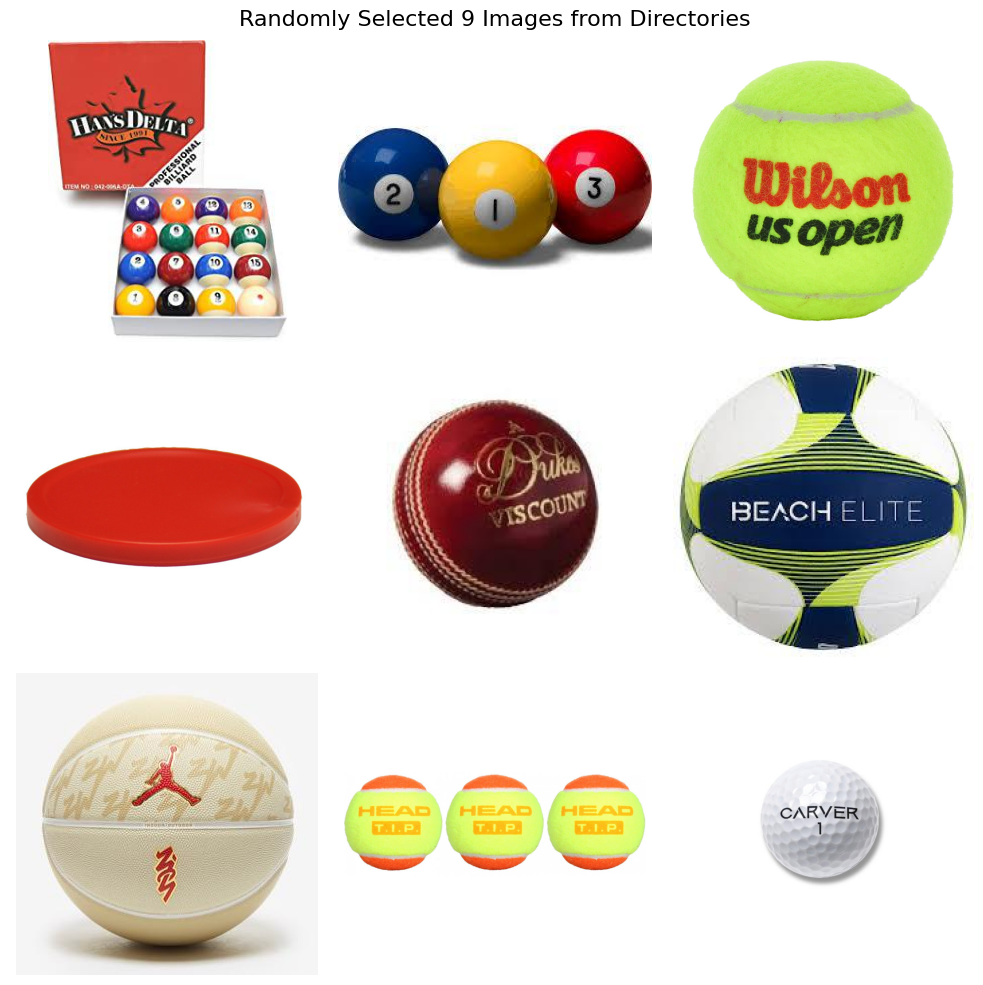

In [9]:
# Plotting the images in a 3x3 grid
plt.figure(figsize = (10, 10))
for i, image_path in enumerate(random_images):
  img = mpimg.imread(image_path)
  plt.subplot(3, 3, i+1)
  plt.imshow(img)
  plt.axis('off')

plt.suptitle('Randomly Selected 9 Images from Directories', fontsize=16)
plt.tight_layout()
plt.show()

##**Data Preparation**

In [10]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [11]:
# Data Augmentation layers (applied during training)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomZoom(0.1),
    layers.RandomRotation(0.1)
])

In [12]:
# Load training and validation datasets using image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

Found 7328 files belonging to 15 classes.
Using 5863 files for training.


In [13]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

Found 7328 files belonging to 15 classes.
Using 1465 files for validation.


In [14]:
# Apply data augmentation only to the training data
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training = True), y))

In [15]:
# Prefetch data for performance improvement
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)

##**Model Building**

In [16]:
from tensorflow.keras import layers, models

# Inception module as defined in the paper
def inception_module(x, filters_1x1, filter_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 convolution
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding = 'same', activation = 'relu')(x)

    # 3x3 convolution
    conv_3x3 = layers.Conv2D(filter_3x3_reduce, (1, 1), padding = 'same', activation = 'relu')(x)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding = 'same', activation = 'relu')(conv_3x3)

    # 5x5 convolution
    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding = 'same', activation = 'relu')(x)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding = 'same', activation = 'relu')(conv_5x5)

    # Max pooling followed by 1x1 convolution
    pool_proj = layers.MaxPooling2D((3, 3), strides = (1, 1), padding = 'same')(x)
    pool_proj = layers.Conv2D(filters_pool_proj, (1, 1), padding = 'same', activation = 'relu')(pool_proj)

    # Concatenate filters from all branches
    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis = -1)
    return output

In [17]:
# Auxiliary classifier for training (deep supervision)
def auxillary_classifier(x, num_classes):
  aux = layers.AveragePooling2D((5, 5), strides = (3, 3))(x)
  aux = layers.Conv2D(128, (1, 1), padding = 'same', activation = 'relu')(aux)
  aux = layers.Flatten()(aux)
  aux = layers.Dense(1024, activation = 'relu')(aux)
  aux = layers.Dropout(0.7)(aux)
  aux = layers.Dense(num_classes, activation = 'softmax')(aux)
  return aux

In [18]:
# Build the GoogLeNet model with two auxiliary classifiers
def build_googlenet(input_shape, num_classes):
  input_layer = layers.Input(shape = input_shape)
  # Normalization layer
  x = layers.Rescaling(1./255)(input_layer)

  # Initial Convolution and MaxPooling
  x = layers.Conv2D(64, (7,7), strides = (2, 2), padding = 'same', activation = 'relu')(x)
  x = layers.MaxPool2D((3,3), strides = (2, 2), padding = 'same')(x)

  # Second Convolution and MaxPooling
  x = layers.Conv2D(192, (3,3), padding = 'same', activation = 'relu')(x)
  x = layers.MaxPooling2D((3, 3), strides = (2, 2), padding = 'same')(x)

  # Inception modules 1 to 4
  x = inception_module(x, 64, 96, 128, 16, 32, 32) # Inception 3a
  x = inception_module(x, 128, 128, 192, 32, 96, 96) # Inception 3b

  x = layers.MaxPooling2D((3, 3), strides = (2, 2), padding = 'same')(x) # MaxPooling after 3b
  x = inception_module(x, 192, 96, 208, 16, 48, 64) # Inception 4a

  # First auxiliary classifier after the 4th inception module
  aux1 = auxillary_classifier(x, num_classes)

  x = inception_module(x, 160, 112, 224, 24, 64, 64) # Inception 4b
  x = inception_module(x, 128, 128, 256, 24, 64, 64) # Inception 4c
  x = inception_module(x, 112, 144, 288, 32, 64, 64) # Inception 4d

  # Second auxillary classifier after the 7th inception module
  aux2 = auxillary_classifier(x, num_classes)

  x = inception_module(x, 256, 160, 320, 32, 128, 128) # Inception 4e

  x = layers.MaxPooling2D((3, 3), strides = (2, 2), padding = 'same')(x) # MaxPooling after 4e

  # Inception modules 8 and 9
  x = inception_module(x, 256, 160, 320, 32, 128, 128) # Inception 5a
  x = inception_module(x, 384, 192, 384, 48, 128, 128) # Inception 5b

  # Global Average Pooling and Dropout
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.4)(x)

  # Output layer
  output_layer = layers.Dense(num_classes, activation = 'softmax')(x)

  # Create the model with inputs and three outputs (main + 2 auxiliary)
  model = models.Model(inputs = input_layer, outputs = [output_layer, aux1, aux2])
  return model

In [19]:
# Model parameters
input_shape = (224, 224, 3) # ImageNet image size
num_classes = 15

# Build the model
googlenet = build_googlenet(input_shape, num_classes)

In [20]:
googlenet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 192)    │        110,784 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 28, 28, 192)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 28, 28, 96)     │         18,528 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 28, 28, 16)     │          3,088 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 192)    │              0 │ max_pooling2d_1[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 28, 28, 64)     │         12,352 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 128)    │        110,720 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 32)     │         12,832 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 32)     │          6,176 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 28, 28, 256)    │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_4[0][0],        │
│                           │                        │                │ conv2d_6[0][0],        │
│                           │                        │                │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 28, 28, 128)    │         32,896 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 28, 28, 32)     │          8,224 │ concatenate[0][0]      │
├──────────────────────

 Total params: 10,365,245 (39.54 MB)

 Trainable params: 10,365,245 (39.54 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(googlenet, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
# Set up directory and parameters
train_dir = '/content/sports-balls-multiclass-image-classification/train'
img_size = (224, 224)
batch_size = 32
num_classes = 15

# Load training and validation datasets using image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

train_dir = "/content/sports-balls-multiclass-image-classification/train"

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Prefetch data for performance improvement
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 7328 files belonging to 15 classes.
Using 5863 files for training.
Found 7328 files belonging to 15 classes.
Using 1465 files for validation.


In [26]:
# Compile the model again after unfreezing layers (lower learning rate for fine-tuning)
googlenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
              loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy','sparse_categorical_crossentropy'],
              metrics=['accuracy', 'accuracy', 'accuracy'])

In [27]:
history = googlenet.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


184/184 ━━━━━━━━━━━━━━━━━━━━ 101s 323ms/step - dense_4_accuracy: 0.0749 - loss: 2.7057 - val_dense_4_accuracy: 0.1215 - val_loss: 2.6855
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 80s 137ms/step - dense_4_accuracy: 0.0954 - loss: 2.6932 - val_dense_4_accuracy: 0.1235 - val_loss: 2.6767
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - dense_4_accuracy: 0.1139 - loss: 2.6757 - val_dense_4_accuracy: 0.1365 - val_loss: 2.5741
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - dense_4_accuracy: 0.1385 - loss: 2.5842 - val_dense_4_accuracy: 0.1713 - val_loss: 2.4831
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - dense_4_accuracy: 0.1624 - loss: 2.5220 - val_dense_4_accuracy: 0.1836 - val_loss: 2.4401


<Axes: >

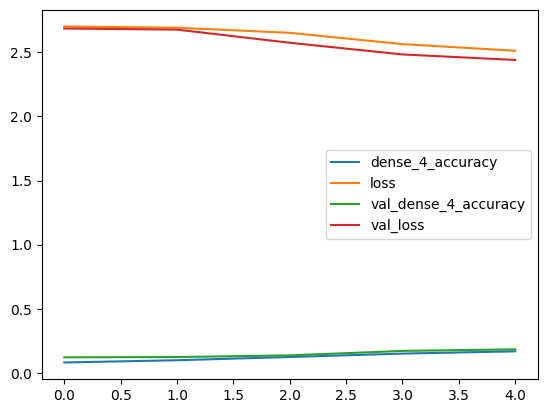

In [28]:
pd.DataFrame(history.history).plot()